In [4]:
import xgboost as xgb
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, confusion_matrix
from sklearn.impute import KNNImputer
from sklearn.model_selection import ShuffleSplit
from sklearn.preprocessing import LabelEncoder,StandardScaler
import numpy as np
from lifelines.utils import concordance_index
import seaborn as sns
import matplotlib.pyplot as plt
import random
import shap
import csv

In [5]:
data = pd.read_csv('./Breast Cancer METABRIC.csv')

In [6]:
data.head()

,Patient ID,Age at Diagnosis,Type of Breast Surgery,Cancer Type,Cancer Type Detailed,Cellularity,Chemotherapy,Pam50 + Claudin-low subtype,Cohort,ER status measured by IHC,...,Overall Survival Status,PR Status,Radio Therapy,Relapse Free Status (Months),Relapse Free Status,Sex,3-Gene classifier subtype,Tumor Size,Tumor Stage,Patient's Vital Status
0,MB-0000,75.65,Mastectomy,Breast Cancer,Breast Invasive Ductal Carcinoma,NaN,No,claudin-low,1.0,Positve,...,Living,Negative,Yes,138.65,Not Recurred,Female,ER-/HER2-,22.0,2.0,Living
1,MB-0002,43.19,Breast Conserving,Breast Cancer,Breast Invasive Ductal Carcinoma,High,No,LumA,1.0,Positve,...,Living,Positive,Yes,83.52,Not Recurred,Female,ER+/HER2- High Prolif,10.0,1.0,Living
2,MB-0005,48.87,Mastectomy,Breast Cancer,Breast Invasive Ductal Carcinoma,High,Yes,LumB,1.0,Positve,...,Deceased,Positive,No,151.28,Recurred,Female,NaN,15.0,2.0,Died of Disease
3,MB-0006,47.68,Mastectomy,Breast Cancer,Breast Mixed Ductal and Lobular Carcinoma,Moderate,Yes,LumB,1.0,Positve,...,Living,Positive,Yes,162.76,Not Recurred,Female,NaN,25.0,2.0,Living
4,MB-0008,76.97,Mastectomy,Breast Cancer,Breast Mixed Ductal and Lobular Carcinoma,High,Yes,LumB,1.0,Positve,...,Deceased,Positive,Yes,18.55,Recurred,Female,ER+/HER2- High Prolif,40.0,2.0,Died of Disease


In [7]:
print(data.shape)

column_list = data.columns.tolist()
print(column_list)


(2509, 34)
['Patient ID', 'Age at Diagnosis', 'Type of Breast Surgery', 'Cancer Type', 'Cancer Type Detailed', 'Cellularity', 'Chemotherapy', 'Pam50 + Claudin-low subtype', 'Cohort', 'ER status measured by IHC', 'ER Status', 'Neoplasm Histologic Grade', 'HER2 status measured by SNP6', 'HER2 Status', 'Tumor Other Histologic Subtype', 'Hormone Therapy', 'Inferred Menopausal State', 'Integrative Cluster', 'Primary Tumor Laterality', 'Lymph nodes examined positive', 'Mutation Count', 'Nottingham prognostic index', 'Oncotree Code', 'Overall Survival (Months)', 'Overall Survival Status', 'PR Status', 'Radio Therapy', 'Relapse Free Status (Months)', 'Relapse Free Status', 'Sex', '3-Gene classifier subtype', 'Tumor Size', 'Tumor Stage', "Patient's Vital Status"]


In [8]:
data.dtypes

Patient ID                         object
Age at Diagnosis                  float64
Type of Breast Surgery             object
Cancer Type                        object
Cancer Type Detailed               object
Cellularity                        object
Chemotherapy                       object
Pam50 + Claudin-low subtype        object
Cohort                            float64
ER status measured by IHC          object
ER Status                          object
Neoplasm Histologic Grade         float64
HER2 status measured by SNP6       object
HER2 Status                        object
Tumor Other Histologic Subtype     object
Hormone Therapy                    object
Inferred Menopausal State          object
Integrative Cluster                object
Primary Tumor Laterality           object
Lymph nodes examined positive     float64
Mutation Count                    float64
Nottingham prognostic index       float64
Oncotree Code                      object
Overall Survival (Months)         

In [9]:
data.isnull().sum()

Patient ID                          0
Age at Diagnosis                   11
Type of Breast Surgery            554
Cancer Type                         0
Cancer Type Detailed                0
Cellularity                       592
Chemotherapy                      529
Pam50 + Claudin-low subtype       529
Cohort                             11
ER status measured by IHC          83
ER Status                          40
Neoplasm Histologic Grade         121
HER2 status measured by SNP6      529
HER2 Status                       529
Tumor Other Histologic Subtype    135
Hormone Therapy                   529
Inferred Menopausal State         529
Integrative Cluster               529
Primary Tumor Laterality          639
Lymph nodes examined positive     266
Mutation Count                    152
Nottingham prognostic index       222
Oncotree Code                       0
Overall Survival (Months)         528
Overall Survival Status           528
PR Status                         529
Radio Therap

In [10]:
data.set_index('Patient ID', inplace=True)

In [11]:
# Encode categorical features
label_encoders = {}
for column in data.columns:
    if data[column].dtype == 'object':
        le = LabelEncoder()
        # Fit the encoder on non-null values only
        non_null_values = data[column][data[column].notnull()]
        le.fit(non_null_values)
        # Transform the column, keeping NaN as is
        data[column] = data[column].apply(lambda x: le.transform([x])[0] if pd.notnull(x) else np.nan)
        label_encoders[column] = le



# Create a CSV file to store the label mappings
with open('label_mappings.csv', mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['Column', 'Category', 'Encoded Value'])
    
    # Write the label mappings for each encoded column
    for column, encoder in label_encoders.items():
        for original_value, encoded_value in zip(encoder.classes_, encoder.transform(encoder.classes_)):
            writer.writerow([column, original_value, encoded_value])


In [12]:
# Making sure missing values are not labelled
data.isnull().sum()

Age at Diagnosis                   11
Type of Breast Surgery            554
Cancer Type                         0
Cancer Type Detailed                0
Cellularity                       592
Chemotherapy                      529
Pam50 + Claudin-low subtype       529
Cohort                             11
ER status measured by IHC          83
ER Status                          40
Neoplasm Histologic Grade         121
HER2 status measured by SNP6      529
HER2 Status                       529
Tumor Other Histologic Subtype    135
Hormone Therapy                   529
Inferred Menopausal State         529
Integrative Cluster               529
Primary Tumor Laterality          639
Lymph nodes examined positive     266
Mutation Count                    152
Nottingham prognostic index       222
Oncotree Code                       0
Overall Survival (Months)         528
Overall Survival Status           528
PR Status                         529
Radio Therapy                     529
Relapse Free

In [13]:
# Handle missing values for both numerical and categorical features using KNN Imputer
knn_imputer = KNNImputer(n_neighbors=20)
data_imputed = pd.DataFrame(knn_imputer.fit_transform(data), columns=data.columns)

In [14]:
data_imputed.isnull().sum()

Age at Diagnosis                  0
Type of Breast Surgery            0
Cancer Type                       0
Cancer Type Detailed              0
Cellularity                       0
Chemotherapy                      0
Pam50 + Claudin-low subtype       0
Cohort                            0
ER status measured by IHC         0
ER Status                         0
Neoplasm Histologic Grade         0
HER2 status measured by SNP6      0
HER2 Status                       0
Tumor Other Histologic Subtype    0
Hormone Therapy                   0
Inferred Menopausal State         0
Integrative Cluster               0
Primary Tumor Laterality          0
Lymph nodes examined positive     0
Mutation Count                    0
Nottingham prognostic index       0
Oncotree Code                     0
Overall Survival (Months)         0
Overall Survival Status           0
PR Status                         0
Radio Therapy                     0
Relapse Free Status (Months)      0
Relapse Free Status         

In [15]:
data_filtered = data_imputed[data_imputed["Patient's Vital Status"] != 1] 

columns_to_exclude = ["Sex", "Patient's Vital Status", "Relapse Free Status", "Relapse Free Status (Months)"]
data_filtered = data_filtered.drop(columns=columns_to_exclude)

data_filtered.shape

(1996, 29)

In [16]:
data_filtered.dtypes

Age at Diagnosis                  float64
Type of Breast Surgery            float64
Cancer Type                       float64
Cancer Type Detailed              float64
Cellularity                       float64
Chemotherapy                      float64
Pam50 + Claudin-low subtype       float64
Cohort                            float64
ER status measured by IHC         float64
ER Status                         float64
Neoplasm Histologic Grade         float64
HER2 status measured by SNP6      float64
HER2 Status                       float64
Tumor Other Histologic Subtype    float64
Hormone Therapy                   float64
Inferred Menopausal State         float64
Integrative Cluster               float64
Primary Tumor Laterality          float64
Lymph nodes examined positive     float64
Mutation Count                    float64
Nottingham prognostic index       float64
Oncotree Code                     float64
Overall Survival (Months)         float64
Overall Survival Status           

In [17]:
#work here

X = data_filtered.drop(['Overall Survival (Months)', 'Overall Survival Status'], axis=1).copy()  
y = data_filtered[['Overall Survival (Months)', 'Overall Survival Status']].copy() 


X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2, 
                                                    random_state=42
                                                    )

In [18]:
# Prepare labels for survival analysis (right-censored)
y_train_lower = y_train['Overall Survival (Months)']
y_train_upper = y_train.apply(lambda row: row['Overall Survival (Months)'] if row['Overall Survival Status'] == 1 else float('inf'), axis=1)
y_train_upper.replace(float('inf'), y_train_lower.max() * 1.5, inplace=True)  # Replace inf with a large value

# Prepare test labels for evaluation
y_test_lower = y_test['Overall Survival (Months)']
y_test_upper = y_test.apply(lambda row: row['Overall Survival (Months)'] if row['Overall Survival Status'] == 1 else float('inf'), axis=1)
y_test_upper.replace(float('inf'), y_test_lower.max() * 1.5, inplace=True)  # Replace inf with a large value


In [19]:
# Convert the datasets into DMatrix for XGBoost with lower and upper bounds
dtrain = xgb.DMatrix(X_train)
dtrain.set_float_info('label_lower_bound', y_train_lower.values)
dtrain.set_float_info('label_upper_bound', y_train_upper.values)

dtest = xgb.DMatrix(X_test)
dtest.set_float_info('label_lower_bound', y_test_lower.values)
dtest.set_float_info('label_upper_bound', y_test_upper.values)

# Convert all datatype to float for xgboost
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

In [20]:
# Parameter optimization
# Attention: relatively time consuming step
# Define the parameter grid for random search
param_grid = {
    'max_depth': [3, 5, 7, 10],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'aft_loss_distribution_scale': [0.5, 1.0, 1.5, 2.0],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'reg_alpha': [0.0, 0.5, 1.0],
    'reg_lambda': [0.5, 1.0, 1.5],
    'min_child_weight': [1, 3, 5],
    'num_boost_round': [50, 100, 200]
    
}


# Define number of iterations for random search
n_iter = 100

# To store the best model and best parameters
best_model = None
best_params = None
best_score = float('inf')

# Random search for hyperparameter optimization
for i in range(n_iter):
    # Randomly sample parameters from the parameter grid
    params = {
        'objective': 'survival:aft',
        'aft_loss_distribution': random.choice(['normal', 'logistic', 'extreme']),
        'aft_loss_distribution_scale': random.choice(param_grid['aft_loss_distribution_scale']),
        'max_depth': random.choice(param_grid['max_depth']),
        'learning_rate': random.choice(param_grid['learning_rate']),
        'subsample': random.choice(param_grid['subsample']),
        'colsample_bytree': random.choice(param_grid['colsample_bytree']),
        'reg_alpha': random.choice(param_grid['reg_alpha']),
        'reg_lambda': random.choice(param_grid['reg_lambda']),
        'min_child_weight': random.choice(param_grid['min_child_weight']),
        'verbosity': 1
        }
    num_boost_round = random.choice(param_grid['num_boost_round'])
    
    # Train the model
    bst = xgb.train(params=params, 
                    dtrain=dtrain, 
                    num_boost_round=num_boost_round, 
                    evals=[(dtest, 'eval')],
                    early_stopping_rounds=50
                    )
    
    # Make predictions on the test set
    preds = bst.predict(dtest)
    
    # Evaluate the model (using Mean Squared Error as the metric)
    mse = mean_squared_error(y_test_lower, preds)
    
    # Update best model if current model is better
    if mse < best_score:
        best_score = mse
        best_model = bst
        best_params = params

# Output the best parameters and the best score
print(f"Best Parameters: {best_params}")
print(f"Best Mean Squared Error (MSE): {best_score}")


[0]	eval-aft-nloglik:16.36947
[1]	eval-aft-nloglik:15.05292
[2]	eval-aft-nloglik:13.86698
[3]	eval-aft-nloglik:12.79127
[4]	eval-aft-nloglik:11.81992
[5]	eval-aft-nloglik:10.94705
[6]	eval-aft-nloglik:10.15735
[7]	eval-aft-nloglik:9.44633
[8]	eval-aft-nloglik:8.80832
[9]	eval-aft-nloglik:8.23008
[10]	eval-aft-nloglik:7.70808
[11]	eval-aft-nloglik:7.24192
[12]	eval-aft-nloglik:6.81535
[13]	eval-aft-nloglik:6.43202
[14]	eval-aft-nloglik:6.08599
[15]	eval-aft-nloglik:5.77452
[16]	eval-aft-nloglik:5.49319
[17]	eval-aft-nloglik:5.23957
[18]	eval-aft-nloglik:5.00906
[19]	eval-aft-nloglik:4.80173
[20]	eval-aft-nloglik:4.61401
[21]	eval-aft-nloglik:4.44699
[22]	eval-aft-nloglik:4.29552
[23]	eval-aft-nloglik:4.15954
[24]	eval-aft-nloglik:4.03611
[25]	eval-aft-nloglik:3.92577
[26]	eval-aft-nloglik:3.82740
[27]	eval-aft-nloglik:3.73658
[28]	eval-aft-nloglik:3.65586
[29]	eval-aft-nloglik:3.58340
[30]	eval-aft-nloglik:3.51699
[31]	eval-aft-nloglik:3.45792
[32]	eval-aft-nloglik:3.40386
[33]	eval-aft

In [21]:
# Evaluate the best model
preds = best_model.predict(dtest)
mse = mean_squared_error(y_test_lower, preds)
rmse = np.sqrt(mse)
r2 = r2_score(y_test_lower, preds)



In [22]:
c_index = concordance_index(y_test_lower, preds)

Concordance Index (C-Index): 0.6072766922758777


In [23]:
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R^2 Score: {r2}")
print(f"Concordance Index (C-Index): {c_index}")

Mean Squared Error (MSE): 5061.094242220363
Root Mean Squared Error (RMSE): 71.14136800919957
R^2 Score: 0.08132871944352493


<Figure size 1000x600 with 0 Axes>

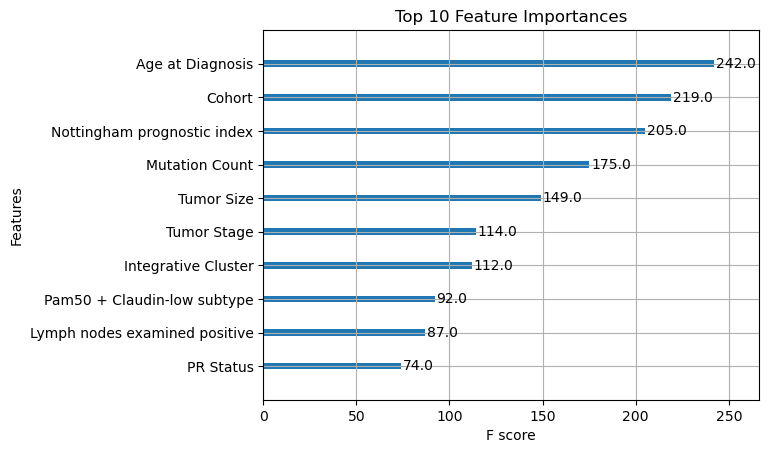

In [24]:
# Visualization: Feature Importance
plt.figure(figsize=(10, 6))
xgb.plot_importance(best_model, max_num_features=10, importance_type='weight')
plt.title('Top 10 Feature Importances')
plt.show()

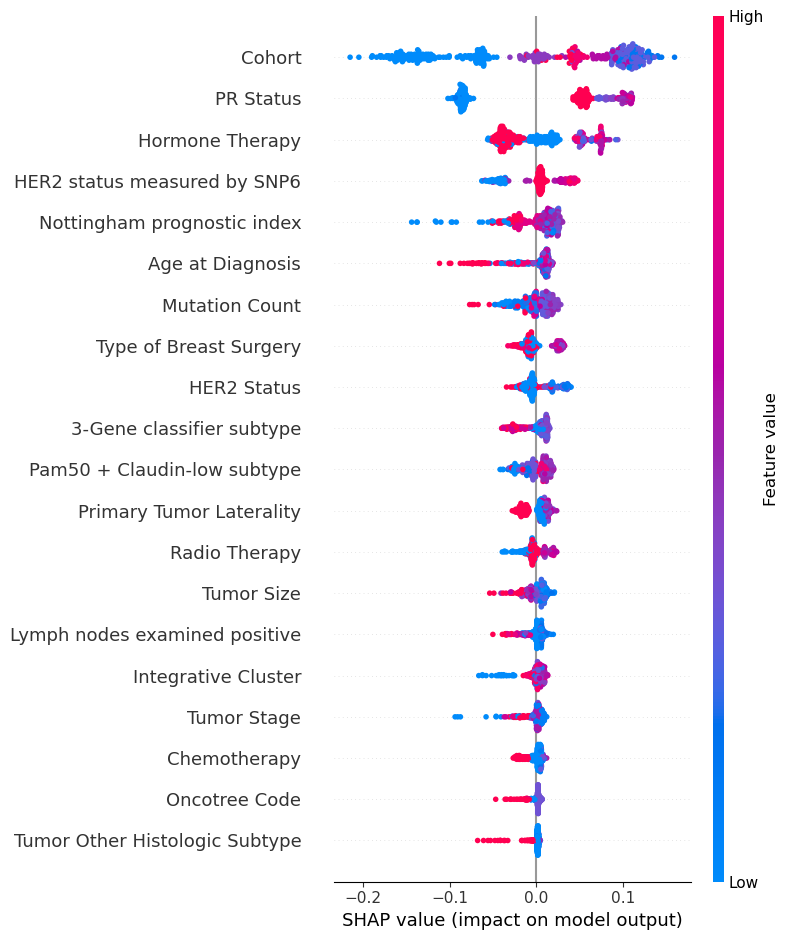

In [25]:
explainer = shap.TreeExplainer(best_model)  # Use TreeExplainer for XGBoost models
shap_values = explainer.shap_values(X_test)

# Summary plot of SHAP values
plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values, X_test)

<Figure size 2000x600 with 0 Axes>

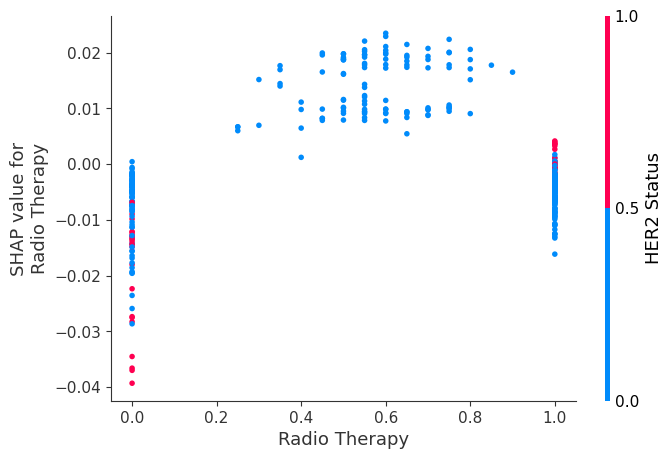

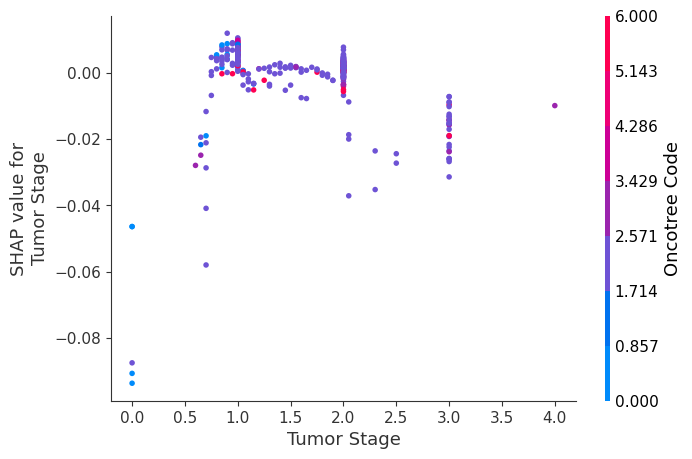

In [26]:
# SHAP Dependence Plot for two specific features
plt.figure(figsize=(20, 6))

shap.dependence_plot('Radio Therapy', shap_values, X_test, interaction_index="HER2 Status")

shap.dependence_plot('Tumor Stage', shap_values, X_test, interaction_index="Oncotree Code")
plt.show()